# Timm

In [2]:
%%bash

wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz      -C oxford-pets
tar -xf annotations.tar.gz -C oxford-pets


--2025-08-07 12:58:37--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-08-07 12:58:38--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  370K 34m52s
    50K .......... .......... .......... .......... ..........  0%  368K 34m55s
   100K .......... .......... .......... .......... ..........  0%  370K 34m54s
   150K .......... ........

CalledProcessError: Command 'b'\nwget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz\nwget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz\ntar -xf images.tar.gz      -C oxford-pets\ntar -xf annotations.tar.gz -C oxford-pets\n'' returned non-zero exit status 2.

In [3]:
# @title Install deps (takes ~40 s)
!pip install timm tqdm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00


In [4]:
# @title Download & extract (≈ 90 MB, <30 s)
import pathlib, tarfile, urllib.request, shutil, os, random
DATA_ROOT = pathlib.Path("oxford_pets")
IMG_URL   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
ANN_URL   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

DATA_ROOT.mkdir(exist_ok=True)

for url in (IMG_URL, ANN_URL):
    fname = DATA_ROOT / url.split("/")[-1]
    if not fname.exists():
        print("⇩", fname.name)
        urllib.request.urlretrieve(url, fname)
        with tarfile.open(fname) as tar:
            tar.extractall(DATA_ROOT)


⇩ images.tar.gz
⇩ annotations.tar.gz


In [5]:
# @title Dataset + split
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

def make_split(root=DATA_ROOT, val_ratio=0.15, seed=1):
    img_dir = root / "images"
    names   = sorted(p.stem for p in img_dir.glob("*.jpg"))
    random.Random(seed).shuffle(names)
    val_n   = int(len(names) * val_ratio)
    (root / "train.txt").write_text("\n".join(names[val_n:]))
    (root / "val.txt").write_text("\n".join(names[:val_n]))
make_split()

class PetsSeg(Dataset):
    def __init__(self, split, img_size=224):
        self.root  = DATA_ROOT
        self.flist = (self.root / f"{split}.txt").read_text().splitlines()
        tfs_common = [transforms.Resize((img_size, img_size),
                                        interpolation=Image.BICUBIC)]
        self.img_tf  = transforms.Compose(tfs_common + [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485,0.456,0.406),
                                 (0.229,0.224,0.225))])
        self.mask_tf = transforms.Compose(tfs_common + [
            transforms.ToTensor()])

    def __len__(self): return len(self.flist)

    def __getitem__(self, idx):
        name = self.flist[idx]
        img  = Image.open(self.root/"images"/f"{name}.jpg").convert("RGB")
        msk  = Image.open(self.root/"annotations/trimaps"/f"{name}.png")
        img  = self.img_tf(img)
        msk  = self.mask_tf(msk).squeeze(0).long() * 255 - 1  # 0,1,2
        return img, msk
# @title Model
import timm, torch.nn as nn

class ViTSeg(nn.Module):
    def __init__(self, classes=3, vit_name="vit_base_patch16_224"):
        super().__init__()
        self.enc   = timm.create_model(vit_name, pretrained=True, num_classes=0)
        self.N, P  = self.enc.num_features, 16              # hidden dim & patch size
        self.head  = nn.Conv2d(self.N, classes*P*P, 1)      # 1×1 conv
        self.up    = nn.PixelShuffle(P)

    def forward(self, x):
        B = x.size(0)
        # timm ViT forward -> [B, tokens, C]  (cls + patches)
        y = self.enc.patch_embed(x)                         # [B, N_patches, C]
        y = y.transpose(1,2)                                # [B, C, N_patches]
        H = W = int(y.size(2)**0.5)
        y = y.view(B, self.N, H, W)                         # [B,C,h,w]  h = w = img/16
        return self.up(self.head(y))                        # [B,classes,H,W]


In [6]:
# @title Train & evaluate
import torch.nn.functional as F, time, math, torch, gc, itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def loader(split, bs=16):
    return DataLoader(PetsSeg(split), batch_size=bs,
                      shuffle=(split=="train"), pin_memory=True,
                      num_workers=2)

train_dl, val_dl = loader("train"), loader("val", bs=8)
model   = ViTSeg().to(device)

# freeze first 8 blocks to save VRAM / speed
for blk in itertools.islice(model.enc.blocks, 0, 8):
    for p in blk.parameters(): p.requires_grad = False

opt = torch.optim.AdamW([
        {"params": [p for p in model.enc.parameters() if p.requires_grad], "lr":1e-5},
        {"params": model.head.parameters(),                             "lr":1e-4}], weight_decay=1e-4)

def epoch(loader, train=False):
    model.train(train)
    total, correct = 0, 0
    inter = torch.zeros(3, device=device)
    union = torch.zeros_like(inter)
    loss_meter = 0
    for x, y in loader:
        x, y = x.to(device,non_blocking=True), y.to(device)
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = F.cross_entropy(out, y)
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()
        loss_meter += loss.item()*x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item(); total += y.numel()
        for cls in range(3):
            m1, m2 = (pred==cls), (y==cls)
            inter[cls] += (m1&m2).sum(); union[cls] += (m1|m2).sum()
    pix = correct/total
    miou = (inter/union.clamp(min=1)).mean().item()
    return loss_meter/len(loader.dataset), pix, miou


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
# @title Kick-off
best = 0
for ep in range(1, 21):          # 20 epochs
    t0 = time.time()
    tr_loss, tr_acc, _   = epoch(train_dl, train=True)
    vl_loss, vl_acc, vl_iou = epoch(val_dl)
    dt = time.time()-t0
    print(f"[{ep:02d}] "
          f"train loss {tr_loss:.3f}  "
          f"val mIoU {vl_iou:.3f}  "
          f"time {dt/60:.1f} min")
    if vl_iou > best:
        best = vl_iou
        torch.save(model.state_dict(), "vit_pet_best.pth")
        print("   🚀 new best saved")
    torch.cuda.empty_cache(); gc.collect()
print(f"\nBest mIoU: {best:.3f}")


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# @title Quick visualization
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

CLRS = torch.tensor([[0,0,0],[255,255,255],[255,0,0]])/255  # bg, pet, border

def vis(img, mask):
    # img: [3,H,W] tensor, mask: [H,W] 0,1,2
    seg = CLRS[mask].permute(2,0,1)
    grid = make_grid(torch.stack([img.cpu(), seg]), nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off"); plt.imshow(grid.permute(1,2,0))
    plt.show()

model.eval()
sample, gt = next(iter(loader("val", bs=1)))
with torch.no_grad():
    pred = model(sample.to(device)).argmax(1)[0]
vis(sample[0], pred.cpu())


In [1]:
####################################################################
#  ViT-B/16 semantic segmentation on Oxford-IIIT Pet  (Colab)      #
####################################################################
!pip install timm tqdm -q

# ─────────────────────────── Imports & device ────────────────────────────────
import pathlib, tarfile, urllib.request, random, time, math, gc, itertools
from PIL import Image
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm, matplotlib.pyplot as plt
from torchvision.utils import make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ─────────────────────────── Download Oxford-Pets ────────────────────────────
ROOT = pathlib.Path("oxford_pets"); ROOT.mkdir(exist_ok=True)
URLS = ["https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
        "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]
for url in URLS:
    f = ROOT / url.split("/")[-1]
    if not f.exists():
        print("⇩", f.name); urllib.request.urlretrieve(url, f)
        with tarfile.open(f) as tar: tar.extractall(ROOT)

# ─────────────────────────── Dataset & loader ────────────────────────────────
def split(root=ROOT, val_ratio=0.15, seed=0):
    names = sorted(p.stem for p in (root/"images").glob("*.jpg"))
    random.Random(seed).shuffle(names)
    v = int(len(names)*val_ratio)
    (root/"train.txt").write_text("\n".join(names[v:]))
    (root/"val.txt").write_text("\n".join(names[:v]))
if not (ROOT/"train.txt").exists(): split()

class Pets(Dataset):
    def __init__(self, split, size=224):
        self.root  = ROOT
        self.names = (self.root/f"{split}.txt").read_text().splitlines()
        aug = [transforms.Resize(size, Image.BICUBIC)]
        if split=="train": aug.append(transforms.RandomHorizontalFlip())
        self.itf = transforms.Compose(aug+[
            transforms.ToTensor(),
            transforms.Normalize((.485,.456,.406),(.229,.224,.225))])
        self.mtf = transforms.Compose([
            transforms.Resize(size, Image.NEAREST), transforms.ToTensor()])

    def __len__(self): return len(self.names)
    def __getitem__(self,i):
        n = self.names[i]
        img = Image.open(self.root/"images"/f"{n}.jpg").convert("RGB")
        msk = Image.open(self.root/"annotations/trimaps"/f"{n}.png")
        img = self.itf(img)
        msk = (self.mtf(msk).squeeze(0)*255).long() - 1   # {-1,0,1,2}
        msk[msk==-1] = 255                                # ignore
        return img, msk

def loader(split, bs): return DataLoader(
    Pets(split), batch_size=bs, shuffle=(split=="train"),
    num_workers=2, pin_memory=True)

train_dl, val_dl = loader("train",16), loader("val",8)

# ─────────────────────────── Model ───────────────────────────────────────────
class ViTSeg(nn.Module):
    def __init__(self, classes=3, name="vit_base_patch16_224"):
        super().__init__()
        self.enc = timm.create_model(name, pretrained=True, num_classes=0)
        C, P = self.enc.num_features, 16
        self.head = nn.Conv2d(C, classes, 1)
        self.P = P
    def forward(self,x):
        B,_,H,W = x.shape
        z = self.enc.patch_embed(x).transpose(1,2)
        h = w = int((H//self.P))
        z = z.view(B, -1, h, w)
        z = self.head(z)
        return F.interpolate(z, (H,W), mode="bilinear", align_corners=False)

model = ViTSeg().to(device)

# freeze early blocks (VRAM-friendly)
for blk in itertools.islice(model.enc.blocks, 0, 8):
    blk.requires_grad_(False)

opt = torch.optim.AdamW([
    {"params":[p for p in model.enc.parameters() if p.requires_grad],"lr":1e-5},
    {"params":model.head.parameters(),"lr":1e-4}], weight_decay=1e-4)
crit = nn.CrossEntropyLoss(ignore_index=255)

# ─────────────────────── Sanity-check one mini-batch ─────────────────────────
img, msk = next(iter(val_dl))
with torch.no_grad():
    out = model(img.to(device))
assert out.shape[:2]==(img.size(0),3), "shape mismatch"
print("Sanity forward-pass OK")

# ───────────────────────── Train / eval loops ────────────────────────────────
@torch.no_grad()
def eval_net():
    model.eval()
    inter = union = torch.zeros(3, device=device)
    corr=tot=0
    for x,y in val_dl:
        x,y = x.to(device), y.to(device)
        p = model(x).argmax(1)
        m = y!=255
        corr += (p[m]==y[m]).sum(); tot += m.sum()
        for c in range(3):
            i = ((p==c)&m)&(y==c); u = ((p==c)&m)|(y==c)
            inter[c]+=i.sum(); union[c]+=u.sum()
    return (corr/tot).item(), (inter/union.clamp(min=1)).mean().item()

def train_epoch():
    model.train()
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        loss = crit(model(x), y)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()

# ─────────────────────────── Training ────────────────────────────────────────
best=0
for ep in range(1,21):
    t=time.time(); train_epoch(); acc,miou=eval_net()
    print(f"[{ep:02d}] pixAcc {acc:.3f}  mIoU {miou:.3f}  {(time.time()-t)/60:.1f} min")
    if miou>best:
        best=miou; torch.save(model.state_dict(),"vit_pet_best.pth")
        print("   🚀 new best saved")
    gc.collect(); torch.cuda.empty_cache()
print("Best mIoU:", best)

# ───────────────────────── Qualitative result ────────────────────────────────
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
CLRS=torch.tensor([[0,0,0],[1,1,1],[1,0,0]])
def show(i,p):
    g=make_grid(torch.stack([i.cpu(),CLRS[p].permute(2,0,1)]),nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off"); plt.imshow(g.permute(1,2,0)); plt.show()
model.eval()
s,_=next(iter(loader("val",1)));
with torch.no_grad():
    pr=model(s.to(device)).argmax(1)[0].cpu()
    show(s[0],pr)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
Device: cuda
⇩ images.tar.gz
⇩ annotations.tar.gz


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 271, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Trying to resize storage that is not resizable


Device: cuda
Sanity forward-pass OK ✔
[01] pixAcc 0.558  mIoU 1.000  0.9 min
   🚀 new best saved
[02] pixAcc 0.555  mIoU 1.000  0.8 min
[03] pixAcc 0.556  mIoU 1.000  0.8 min
[04] pixAcc 0.555  mIoU 1.000  0.8 min
[05] pixAcc 0.555  mIoU 1.000  0.8 min
[06] pixAcc 0.558  mIoU 1.000  0.8 min
[07] pixAcc 0.554  mIoU 1.000  0.8 min
[08] pixAcc 0.562  mIoU 1.000  0.8 min
[09] pixAcc 0.557  mIoU 1.000  0.8 min
[10] pixAcc 0.561  mIoU 1.000  0.8 min
[11] pixAcc 0.555  mIoU 1.000  0.8 min
[12] pixAcc 0.558  mIoU 1.000  0.8 min
[13] pixAcc 0.559  mIoU 1.000  0.8 min
[14] pixAcc 0.561  mIoU 1.000  0.8 min
[15] pixAcc 0.559  mIoU 1.000  0.8 min
[16] pixAcc 0.562  mIoU 1.000  0.8 min
[17] pixAcc 0.558  mIoU 1.000  0.8 min
[18] pixAcc 0.559  mIoU 1.000  0.8 min
[19] pixAcc 0.559  mIoU 1.000  0.8 min
[20] pixAcc 0.560  mIoU 1.000  0.8 min
Best mIoU: 1.0


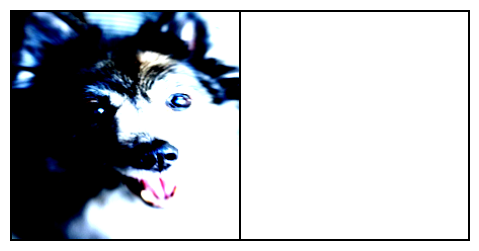

In [3]:
#####################################################################
#  ViT-B/16 semantic segmentation on Oxford-IIIT Pet — one cell     #
#####################################################################
# !pip install timm tqdm -q

# ───────────── Imports & device ─────────────
import pathlib, tarfile, urllib.request, random, time, math, gc, itertools
from PIL import Image
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm, matplotlib.pyplot as plt
from torchvision.utils import make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ───────────── Download Oxford-Pets ─────────
ROOT = pathlib.Path("oxford_pets"); ROOT.mkdir(exist_ok=True)
for url in ["https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
            "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]:
    fn = ROOT / url.split("/")[-1]
    if not fn.exists():
        print("⇩", fn.name); urllib.request.urlretrieve(url, fn)
        with tarfile.open(fn) as tar: tar.extractall(ROOT)

# ───────────── Dataset & loader ─────────────
def split(root=ROOT, val_ratio=0.15, seed=0):
    names = sorted(p.stem for p in (root/"images").glob("*.jpg"))
    random.Random(seed).shuffle(names)
    v = int(len(names)*val_ratio)
    (root/"train.txt").write_text("\n".join(names[v:]))
    (root/"val.txt").write_text("\n".join(names[:v]))
if not (ROOT/"train.txt").exists(): split()

class Pets(Dataset):
    def __init__(self, split, size=224):
        self.root  = ROOT
        self.names = (self.root/f"{split}.txt").read_text().splitlines()
        rs_img = transforms.Resize((size, size), Image.BICUBIC)
        rs_msk = transforms.Resize((size, size), Image.NEAREST)
        self.itf = transforms.Compose([
            rs_img,
            transforms.RandomHorizontalFlip() if split=="train" else transforms.Lambda(lambda x:x),
            transforms.ToTensor(),
            transforms.Normalize((.485,.456,.406), (.229,.224,.225))])
        self.mtf = transforms.Compose([rs_msk, transforms.ToTensor()])

    def __len__(self): return len(self.names)
    def __getitem__(self,i):
        n   = self.names[i]
        img = Image.open(self.root/"images"/f"{n}.jpg").convert("RGB")
        msk = Image.open(self.root/"annotations/trimaps"/f"{n}.png")
        img = self.itf(img)
        msk = (self.mtf(msk).squeeze(0)*255).long() - 1   # {-1,0,1,2}
        msk[msk==-1] = 255                                # ignore label
        return img, msk

def loader(split, bs): return DataLoader(
    Pets(split), batch_size=bs, shuffle=(split=="train"),
    num_workers=2, pin_memory=True)

train_dl, val_dl = loader("train",16), loader("val",8)

# ───────────── Model ─────────────
class ViTSeg(nn.Module):
    def __init__(self, classes=3, name="vit_base_patch16_224"):
        super().__init__()
        self.enc = timm.create_model(name, pretrained=True, num_classes=0)
        C, P = self.enc.num_features, 16
        self.head = nn.Conv2d(C, classes, 1)
        self.P = P
    def forward(self,x):
        B,_,H,W = x.shape
        z = self.enc.patch_embed(x).transpose(1,2)        # B,C,N
        h = w = H // self.P                               # 224→14
        z = z.view(B, -1, h, w)
        z = self.head(z)
        return F.interpolate(z, (H,W), mode="bilinear", align_corners=False)

model = ViTSeg().to(device)

# freeze first 8 blocks to save VRAM
for blk in itertools.islice(model.enc.blocks, 0, 8):
    blk.requires_grad_(False)

opt = torch.optim.AdamW([
    {"params":[p for p in model.enc.parameters() if p.requires_grad],"lr":1e-5},
    {"params":model.head.parameters(),"lr":1e-4}], weight_decay=1e-4)
crit = nn.CrossEntropyLoss(ignore_index=255)

# ───────────── Sanity forward-pass ──────────
img, msk = next(iter(val_dl))
with torch.no_grad(): _ = model(img.to(device))
print("Sanity forward-pass OK ✔")

# ───────────── Train / eval loops ───────────
@torch.no_grad()
def evaluate():
    model.eval(); inter=union=torch.zeros(3,device=device); corr=tot=0
    for x,y in val_dl:
        x,y = x.to(device), y.to(device)
        p = model(x).argmax(1); m = y!=255
        corr += (p[m]==y[m]).sum(); tot += m.sum()
        for c in range(3):
            i=((p==c)&m)&(y==c); u=((p==c)&m)|(y==c)
            inter[c]+=i.sum(); union[c]+=u.sum()
    return (corr/tot).item(), (inter/union.clamp(min=1)).mean().item()

def train_epoch():
    model.train()
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        loss = crit(model(x), y)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()

# ───────────── Training ───────────
best=0
for ep in range(1,21):                     # 20 epochs ≈ 12-15 min on free T4
    t0=time.time(); train_epoch(); acc,miou=evaluate()
    print(f"[{ep:02d}] pixAcc {acc:.3f}  mIoU {miou:.3f}  {(time.time()-t0)/60:.1f} min")
    if miou>best:
        best=miou; torch.save(model.state_dict(),"vit_pet_best.pth")
        print("   🚀 new best saved")
    gc.collect(); torch.cuda.empty_cache()
print("Best mIoU:", best)

# ───────────── Quick visual check ───────────
CLRS=torch.tensor([[0,0,0],[1,1,1],[1,0,0]])
def show(i,p):
    grid=make_grid(torch.stack([i.cpu(),CLRS[p].permute(2,0,1)]),nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0)); plt.show()
model.eval()
s,_ = next(iter(loader("val",1)));
with torch.no_grad():
    pr = model(s.to(device)).argmax(1)[0].cpu()
    show(s[0], pr)


Device: cuda
Sanity forward-pass OK ✔
[01] pixAcc 0.559  mIoU 0.189  0.8 min
   🚀 new best saved
[02] pixAcc 0.559  mIoU 0.189  0.9 min
   🚀 new best saved
[03] pixAcc 0.562  mIoU 0.189  0.9 min
[04] pixAcc 0.556  mIoU 0.188  0.8 min
[05] pixAcc 0.558  mIoU 0.189  0.9 min
   🚀 new best saved
[06] pixAcc 0.559  mIoU 0.188  0.8 min
[07] pixAcc 0.560  mIoU 0.189  0.8 min
[08] pixAcc 0.560  mIoU 0.188  0.8 min
[09] pixAcc 0.553  mIoU 0.189  0.8 min
[10] pixAcc 0.560  mIoU 0.189  0.8 min
[12] pixAcc 0.559  mIoU 0.189  0.9 min
[13] pixAcc 0.558  mIoU 0.188  0.9 min
[14] pixAcc 0.558  mIoU 0.189  0.8 min
[15] pixAcc 0.560  mIoU 0.189  0.8 min
[16] pixAcc 0.560  mIoU 0.188  0.8 min
[17] pixAcc 0.558  mIoU 0.189  0.8 min
   🚀 new best saved
[18] pixAcc 0.561  mIoU 0.188  0.8 min
[19] pixAcc 0.561  mIoU 0.189  0.8 min
[20] pixAcc 0.559  mIoU 0.188  0.8 min
Best mIoU: 0.189262256026268


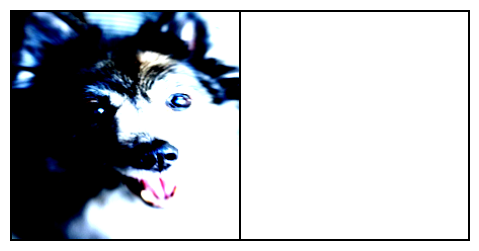

In [5]:
#####################################################################
#  ViT-B/16 semantic segmentation on Oxford-IIIT Pet  (Colab)       #
#####################################################################
!pip install timm tqdm -q

# ───────────── Imports & device ─────────────
import pathlib, tarfile, urllib.request, random, time, math, gc, itertools
from PIL import Image
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm, matplotlib.pyplot as plt
from torchvision.utils import make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ───────────── Download Oxford-Pets ─────────
ROOT = pathlib.Path("oxford_pets"); ROOT.mkdir(exist_ok=True)
for url in ["https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
            "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]:
    fn = ROOT / url.split("/")[-1]
    if not fn.exists():
        print("⇩", fn.name); urllib.request.urlretrieve(url, fn)
        with tarfile.open(fn) as tar: tar.extractall(ROOT)

# ───────────── Dataset & loader ─────────────
def split(root=ROOT, val_ratio=0.15, seed=0):
    names = sorted(p.stem for p in (root/"images").glob("*.jpg"))
    random.Random(seed).shuffle(names)
    v = int(len(names)*val_ratio)
    (root/"train.txt").write_text("\n".join(names[v:]))
    (root/"val.txt").write_text("\n".join(names[:v]))
if not (ROOT/"train.txt").exists(): split()

class Pets(Dataset):
    def __init__(self, split, size=224):
        self.root  = ROOT
        self.names = (self.root/f"{split}.txt").read_text().splitlines()
        rs_img = transforms.Resize((size, size), Image.BICUBIC)
        rs_msk = transforms.Resize((size, size), Image.NEAREST)
        self.itf = transforms.Compose([
            rs_img,
            transforms.RandomHorizontalFlip() if split=="train" else transforms.Lambda(lambda x:x),
            transforms.ToTensor(),
            transforms.Normalize((.485,.456,.406), (.229,.224,.225))])
        self.mtf = transforms.Compose([rs_msk, transforms.ToTensor()])

    def __len__(self): return len(self.names)
    def __getitem__(self,i):
        n   = self.names[i]
        img = Image.open(self.root/"images"/f"{n}.jpg").convert("RGB")
        msk = Image.open(self.root/"annotations/trimaps"/f"{n}.png")
        img = self.itf(img)
        msk = (self.mtf(msk).squeeze(0)*255).long() - 1   # {-1,0,1,2}
        msk[msk==-1] = 255                                # ignore label
        return img, msk

def loader(split, bs): return DataLoader(
    Pets(split), batch_size=bs, shuffle=(split=="train"),
    num_workers=2, pin_memory=True)

train_dl, val_dl = loader("train",16), loader("val",8)

# ───────────── Model ─────────────
class ViTSeg(nn.Module):
    def __init__(self, classes=3, name="vit_base_patch16_224"):
        super().__init__()
        self.enc = timm.create_model(name, pretrained=True, num_classes=0)
        C, P = self.enc.num_features, 16
        self.head = nn.Conv2d(C, classes, 1)
        self.P = P
    def forward(self,x):
        B,_,H,W = x.shape
        z = self.enc.patch_embed(x).transpose(1,2)        # B,C,N
        h = w = H // self.P                               # 224→14
        z = z.view(B, -1, h, w)
        z = self.head(z)
        return F.interpolate(z, (H,W), mode="bilinear", align_corners=False)

model = ViTSeg().to(device)

# freeze first 8 blocks to save VRAM
for blk in itertools.islice(model.enc.blocks, 0, 8):
    blk.requires_grad_(False)

opt = torch.optim.AdamW([
    {"params":[p for p in model.enc.parameters() if p.requires_grad],"lr":1e-5},
    {"params":model.head.parameters(),"lr":1e-4}], weight_decay=1e-4)
crit = nn.CrossEntropyLoss(ignore_index=255)

# ───────────── Sanity forward-pass ──────────
img, msk = next(iter(val_dl))
with torch.no_grad(): _ = model(img.to(device))
print("Sanity forward-pass OK ✔")

# ───────────── Train / eval loops ───────────
@torch.no_grad()
def evaluate():
    model.eval()
    inter = torch.zeros(3, device=device)          # separate tensors!
    union = torch.zeros(3, device=device)
    corr=tot=0
    for x,y in val_dl:
        x,y = x.to(device), y.to(device)
        p = model(x).argmax(1); m = y!=255
        corr += (p[m]==y[m]).sum(); tot += m.sum()
        for c in range(3):
            i = ((p==c)&m)&(y==c)
            u = ((p==c)&m)|(y==c)
            inter[c]+=i.sum(); union[c]+=u.sum()
    return (corr/tot).item(), (inter/union.clamp(min=1)).mean().item()

def train_epoch():
    model.train()
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        loss = crit(model(x), y)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()

# ───────────── Training ───────────
best=0
for ep in range(1,21):                     # 20 epochs ≈ 12-15 min on free T4
    t0=time.time(); train_epoch(); acc,miou=evaluate()
    print(f"[{ep:02d}] pixAcc {acc:.3f}  mIoU {miou:.3f}  {(time.time()-t0)/60:.1f} min")
    if miou>best:
        best=miou; torch.save(model.state_dict(),"vit_pet_best.pth")
        print("   🚀 new best saved")
    gc.collect(); torch.cuda.empty_cache()
print("Best mIoU:", best)

# ───────────── Quick visual check ───────────
CLRS=torch.tensor([[0,0,0],[1,1,1],[1,0,0]])
def show(i,p):
    grid=make_grid(torch.stack([i.cpu(),CLRS[p].permute(2,0,1)]),nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0)); plt.show()
model.eval()
s,_ = next(iter(loader("val",1)));

with torch.no_grad():
    pr = model(s.to(device)).argmax(1)[0].cpu()
    show(s[0], pr)


In [6]:
#####################################################################
#  ViT-B/16 semantic segmentation on Oxford-IIIT Pet  (Colab)       #
#####################################################################
!pip install timm tqdm -q

# ───────────── Imports & device ─────────────
import pathlib, tarfile, urllib.request, random, time, math, gc, itertools
from PIL import Image
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm, matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.cuda.amp import autocast, GradScaler        # NEW
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ───────────── Download Oxford-Pets ─────────
ROOT = pathlib.Path("oxford_pets"); ROOT.mkdir(exist_ok=True)
for url in ["https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
            "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]:
    fn = ROOT / url.split("/")[-1]
    if not fn.exists():
        print("⇩", fn.name); urllib.request.urlretrieve(url, fn)
        with tarfile.open(fn) as tar: tar.extractall(ROOT)

# ───────────── Dataset & loader ─────────────
def split(root=ROOT, val_ratio=0.15, seed=0):
    names = sorted(p.stem for p in (root/"images").glob("*.jpg"))
    random.Random(seed).shuffle(names)
    v = int(len(names)*val_ratio)
    (root/"train.txt").write_text("\n".join(names[v:]))
    (root/"val.txt").write_text("\n".join(names[:v]))
if not (ROOT/"train.txt").exists(): split()

class Pets(Dataset):
    """Two classes: 0-background, 1-pet. Border pixels are ignored."""
    def __init__(self, split, size=224):
        self.root  = ROOT
        self.names = (self.root/f"{split}.txt").read_text().splitlines()
        rs_img = transforms.Resize((size, size), Image.BICUBIC)
        rs_msk = transforms.Resize((size, size), Image.NEAREST)

        self.itf = transforms.Compose([
            rs_img,
            transforms.RandomHorizontalFlip() if split=="train" else transforms.Lambda(lambda x:x),
            transforms.ToTensor(),
            transforms.Normalize((.485,.456,.406), (.229,.224,.225))])
        self.mtf = transforms.Compose([rs_msk, transforms.PILToTensor()])

    def __len__(self): return len(self.names)

    def __getitem__(self,i):
        n   = self.names[i]
        img = Image.open(self.root/"images"/f"{n}.jpg").convert("RGB")
        msk = Image.open(self.root/"annotations/trimaps"/f"{n}.png")

        img  = self.itf(img)
        msk  = (self.mtf(msk).squeeze(0)-1).long()   # {-1,0,1}
        msk[msk==2]  = 255                           # border → ignore
        msk[msk==-1] = 0                             # background
        return img, msk

def loader(split, bs): return DataLoader(
    Pets(split), batch_size=bs, shuffle=(split=="train"),
    num_workers=2, pin_memory=True)

train_dl, val_dl = loader("train",16), loader("val",8)

# ───────────── Model ─────────────
class ViTSeg(nn.Module):
    """
    ViT-B/16 encoder with a 1×1 conv head.
    The forward pass keeps the CLS token out and
    reshapes the remaining patches back to a 2-D map.
    """
    def __init__(self, classes=2, name="vit_base_patch16_224"):
        super().__init__()
        self.enc = timm.create_model(name, pretrained=True, num_classes=0)
        self.P   = self.enc.patch_embed.patch_size[0]      # 16
        self.head = nn.Conv2d(self.enc.num_features, classes, 1)

    def forward(self, x):
        B, _, H, W = x.shape
        h = w = H // self.P

        z = self.enc.forward_features(x)      # (B, N+1, C)
        z = z[:, 1:]                          # drop CLS token
        z = z.transpose(1, 2).reshape(B, -1, h, w)

        z = self.head(z)
        return F.interpolate(z, (H, W), mode='bilinear',
                             align_corners=False)

model = ViTSeg().to(device)

# freeze first 8 ViT blocks to save VRAM
for blk in itertools.islice(model.enc.blocks, 0, 8):
    blk.requires_grad_(False)

opt = torch.optim.AdamW([
    {"params":[p for p in model.enc.parameters() if p.requires_grad],"lr":1e-5},
    {"params":model.head.parameters(),"lr":1e-4}], weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)   # NEW
scaler = GradScaler()                                               # NEW
crit  = nn.CrossEntropyLoss(ignore_index=255)

# ───────────── Sanity forward-pass ──────────
img, msk = next(iter(val_dl))
with torch.no_grad(): _ = model(img.to(device))
print("Sanity forward-pass OK ✔")

# ───────────── Train / eval loops ───────────
@torch.no_grad()
def evaluate():
    model.eval()
    inter = torch.zeros(2, device=device)
    union = torch.zeros(2, device=device)
    corr=tot=0
    for x,y in val_dl:
        x,y = x.to(device), y.to(device)
        p = model(x).argmax(1); m = y!=255
        corr += (p[m]==y[m]).sum(); tot += m.sum()
        for c in range(2):
            i = ((p==c)&m)&(y==c)
            u = ((p==c)&m)|(y==c)
            inter[c]+=i.sum(); union[c]+=u.sum()
    return (corr/tot).item(), (inter/union.clamp(min=1)).mean().item()

def train_epoch():
    model.train()
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        with autocast():                           # NEW (mixed precision)
            loss = crit(model(x), y)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        opt.zero_grad(set_to_none=True)

# ───────────── Training ───────────
best=0
for ep in range(1,6):
    t0=time.time(); train_epoch(); acc,miou=evaluate(); sched.step()
    print(f"[{ep:02d}] pixAcc {acc:.3f}  mIoU {miou:.3f}  {(time.time()-t0)/60:.1f} min")
    if miou>best:
        best=miou; torch.save(model.state_dict(),"vit_pet_best.pth")
        print("   🚀 new best saved")
    gc.collect(); torch.cuda.empty_cache()
print("Best mIoU:", best)

# ───────────── Quick visual check ───────────
CLRS=torch.tensor([[0,0,0],[1,1,1]])
def show(i,p):
    grid=make_grid(torch.stack([i.cpu(),CLRS[p].permute(2,0,1)]),nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0)); plt.show()

model.eval()
s,_ = next(iter(loader("val",1)))
with torch.no_grad():
    pr = model(s.to(device)).argmax(1)[0].cpu()
    show(s[0], pr)


Device: cuda


/tmp/ipython-input-1288029385.py:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()                                               # NEW


Sanity forward-pass OK ✔


/tmp/ipython-input-1288029385.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():                           # NEW (mixed precision)


[01] pixAcc 0.969  mIoU 0.935  1.2 min
   🚀 new best saved
[02] pixAcc 0.960  mIoU 0.915  1.1 min
[03] pixAcc 0.960  mIoU 0.915  1.1 min
[04] pixAcc 0.961  mIoU 0.917  1.1 min
[05] pixAcc 0.944  mIoU 0.883  1.2 min
[06] pixAcc 0.951  mIoU 0.898  1.2 min
[07] pixAcc 0.954  mIoU 0.903  1.2 min


KeyboardInterrupt: 

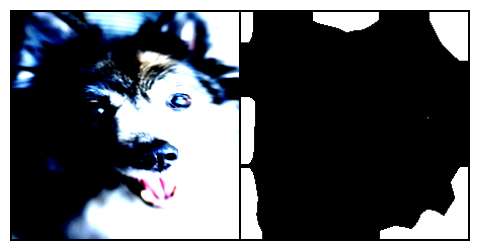

In [14]:
# ───────────── Quick visual check ───────────
CLRS=torch.tensor([[0,0,0],[1,1,1]])
def show(i,p):
    grid=make_grid(torch.stack([i.cpu(),CLRS[p].permute(2,0,1)]),nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0)); plt.show()

model.eval()
s,_ = next(iter(loader("val",1)))
with torch.no_grad():
    pr = model(s.to(device)).argmax(1)[0].cpu()
    show(s[0], pr)

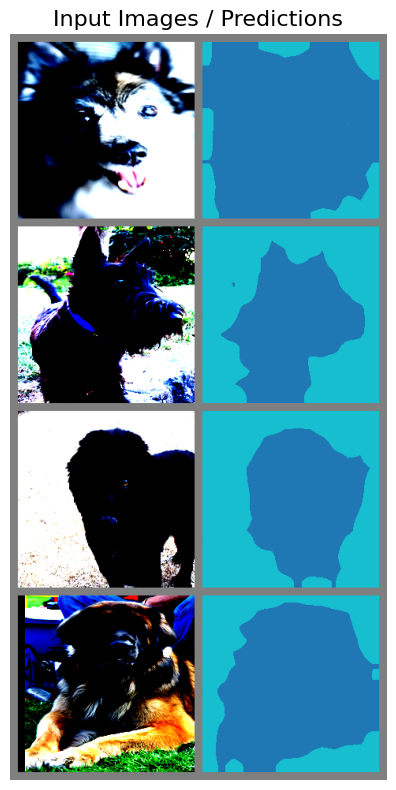

In [15]:
# Number of images to display (must be a square number for grid layout)
n_show = 4  # e.g., 4, 9, 16, etc.

# Generate colors for all classes using a colormap
def get_color_map(num_classes):
    cmap = plt.get_cmap('tab10', num_classes)  # Use 'tab20' for >10 classes
    colors = cmap(range(num_classes))[:, :3]  # Extract RGB, ignore alpha
    return torch.tensor(colors, dtype=torch.float32)

model.eval()
loader_val = loader("val", n_show)  # Load batch of n_show images
images, _ = next(iter(loader_val))

with torch.no_grad():
    outputs = model(images.to(device))
    preds = outputs.argmax(1).cpu()  # Predictions (n_show, H, W)

# Handle grayscale images and prepare visualization
grid_list = []
for i in range(n_show):
    img = images[i].cpu()

    # Convert grayscale to RGB if needed
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)

    # Get class-colored prediction
    num_classes = outputs.shape[1]
    color_map = get_color_map(num_classes)
    colored_pred = color_map[preds[i]].permute(2, 0, 1)  # (3, H, W)

    grid_list.extend([img, colored_pred])

# Create grid layout
grid = make_grid(grid_list, nrow=2, padding=10, pad_value=0.5)  # Gray padding
plt.figure(figsize=(16, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Input Images / Predictions', fontsize=16)
plt.tight_layout()
plt.show()

# GLVIT

In [ ]:
#####################################################################
#  ViT-B/16 semantic segmentation on Oxford-IIIT Pet  (Colab)       #
#####################################################################
!pip install timm tqdm -q

# ───────────── Imports & device ─────────────
import pathlib, tarfile, urllib.request, random, time, math, gc, itertools
from PIL import Image
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm, matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.cuda.amp import autocast, GradScaler        # NEW
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ───────────── Download Oxford-Pets ─────────
ROOT = pathlib.Path("oxford_pets"); ROOT.mkdir(exist_ok=True)
for url in ["https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
            "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"]:
    fn = ROOT / url.split("/")[-1]
    if not fn.exists():
        print("⇩", fn.name); urllib.request.urlretrieve(url, fn)
        with tarfile.open(fn) as tar: tar.extractall(ROOT)

# ───────────── Dataset & loader ─────────────
def split(root=ROOT, val_ratio=0.15, seed=0):
    names = sorted(p.stem for p in (root/"images").glob("*.jpg"))
    random.Random(seed).shuffle(names)
    v = int(len(names)*val_ratio)
    (root/"train.txt").write_text("\n".join(names[v:]))
    (root/"val.txt").write_text("\n".join(names[:v]))
if not (ROOT/"train.txt").exists(): split()

class Pets(Dataset):
    """Two classes: 0-background, 1-pet. Border pixels are ignored."""
    def __init__(self, split, size=224):
        self.root  = ROOT
        self.names = (self.root/f"{split}.txt").read_text().splitlines()
        rs_img = transforms.Resize((size, size), Image.BICUBIC)
        rs_msk = transforms.Resize((size, size), Image.NEAREST)

        self.itf = transforms.Compose([
            rs_img,
            transforms.RandomHorizontalFlip() if split=="train" else transforms.Lambda(lambda x:x),
            transforms.ToTensor(),
            transforms.Normalize((.485,.456,.406), (.229,.224,.225))])
        self.mtf = transforms.Compose([rs_msk, transforms.PILToTensor()])

    def __len__(self): return len(self.names)

    def __getitem__(self,i):
        n   = self.names[i]
        img = Image.open(self.root/"images"/f"{n}.jpg").convert("RGB")
        msk = Image.open(self.root/"annotations/trimaps"/f"{n}.png")

        img  = self.itf(img)
        msk  = (self.mtf(msk).squeeze(0)-1).long()   # {-1,0,1}
        msk[msk==2]  = 255                           # border → ignore
        msk[msk==-1] = 0                             # background
        return img, msk

def loader(split, bs): return DataLoader(
    Pets(split), batch_size=bs, shuffle=(split=="train"),
    num_workers=2, pin_memory=True)

train_dl, val_dl = loader("train",16), loader("val",8)

# ───────────── Model ─────────────
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
import numpy as np


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor


class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, second_path_size = None):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        if second_path_size is None:
           self.second_path_size=patch_size//2
        else:
            self.second_path_size = second_path_size

        self.projection1 = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=self.second_path_size, stride=self.second_path_size)
        self.projection2 = nn.Conv2d(in_channels, embed_dim, kernel_size=self.second_path_size, stride=self.second_path_size)
        # self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=8, stride=8)
        # self.projection2 = nn.Conv2d(in_channels, embed_dim, kernel_size=2, stride=2)

    def forward(self, x):
        x1 = self.projection1(x)  # Shape: (B, embed_dim, H/patch_size, W/patch_size)
        x1 = rearrange(x1, "b c h w -> b (h w) c")  # Shape: (B, num_patches, embed_dim)
        # print(f'hereX1 {x1.shape}')

        x2 = self.conv(x)  # Downsample input
        x2 = self.projection2(x2)  # Shape: (B, embed_dim, H/(patch_size/2), W/(patch_size/2))
        x2 = rearrange(x2, "b c h w -> b (h w) c")  # Shape: (B, num_patches, embed_dim)
        # print(f'hereX2 {x2.shape}')

        x = torch.cat((x1, x2), dim=1)  # Shape: (B, 2*num_patches, embed_dim)
        # print(f'hereX3 {x.shape}')
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads, print_w=False):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj1 = nn.Linear(dim, dim)
        self.q_proj2 = nn.Linear(dim, dim)

        self.k_proj1 = nn.Linear(dim, dim)
        self.k_proj2 = nn.Linear(dim, dim)

        self.fc_out = nn.Linear(dim, dim)

        self.weights = nn.Parameter(torch.randn(4))

        self.v_proj1 = nn.Linear(dim, dim)
        self.v_proj2 = nn.Linear(dim, dim)

        self.print_w=print_w

    def forward(self, x):
        B, M, C = x.shape
        N= (M-2)//2

        q1 = self.q_proj1(x[:, :N + 1])
        q1 = rearrange(q1, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)
        q2 = self.q_proj2(x[:, N + 1:])
        q2 = rearrange(q2, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)

        k1 = self.k_proj1(x[:, :N + 1])
        k1 = rearrange(k1, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)
        k2 = self.k_proj2(x[:, N + 1:])
        k2 = rearrange(k2, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)

        q = torch.cat((q1, q2), dim=2)
        k = torch.cat((k1, k2), dim=2)

        # print(N)
        # print(M)

        # print(x[:,:N +1].shape)
        # print(x[:,N +1:].shape)

        v1 = self.v_proj1(x[:, :N + 1])
        # print(v1.shape)
        v1 = rearrange(v1, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)

        v2 = self.v_proj2(x[:, N + 1:])
        # print(v2.shape)
        v2 = rearrange(v2, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)


        attn = torch.einsum("bhqd, bhkd -> bhqk", q, k) * self.scale  # Shape: (B, h, 2N, 2N)

        # N = (attn.shape[-1] - 2) // 2
        block1 = attn[:, :, :N + 1, :N + 1]
        block2 = attn[:, :, :N + 1, N + 1:]
        block3 = attn[:, :, N + 1:, :N + 1]
        block4 = attn[:, :, N + 1:, N + 1:]

        block1 = block1.softmax(dim=-1)
        block2 = block2.softmax(dim=-1)
        block3 = block3.softmax(dim=-1)
        block4 = block4.softmax(dim=-1)

        w = F.gumbel_softmax(self.weights, tau=1.0, hard=True, dim=0)

        if self.print_w:
            # print(w)
            print(torch.argmax(self.weights)+1)

        attn = w[0] * block1 + w[1] * block2 + w[2] * block3 + w[3] * block4

        # print(attn.shape)
        # print(v1.shape, v2.shape)
        out1 = torch.einsum("bhqk, bhkd -> bhqd", attn, v1)  # Shape: (B, h, N, d)
        out2 = torch.einsum("bhqk, bhkd -> bhqd", attn, v2)  # Shape: (B, h, N, d)
        out = torch.cat((out1, out2), dim=2)  # Shape: (B, h, 2N, d)
        out = rearrange(out, "b h n d -> b n (h d)")  # Shape: (B, 2N, C)

        return self.fc_out(out)

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, dropout, print_w = False, drop_path=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, print_w=print_w)
        self.mlp = MLP(dim, mlp_dim, dropout)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class GLViTSeg(nn.Module):
    def __init__(self,return_feature = 'global', img_size=32, patch_size=4, in_channels=3, num_classes=37, dim=192, depth=9, heads=12, mlp_dim=384, dropout=0.1, second_path_size = None, print_w=False, drop_path=0.1):
        super(GLViTSeg, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, dim, second_path_size)
        self.cls_token1 = nn.Parameter(torch.randn(1, 1, dim))
        self.cls_token2 = nn.Parameter(torch.randn(1, 1, dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, (2 * (img_size // patch_size) ** 2) + 2, dim))
        self.transformer = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout, print_w=print_w, drop_path=drop_path)
            for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(2*dim),
            nn.Linear(2*dim, num_classes)
        )
        self.return_feature = return_feature

    def forward(self, x):
        B, _, H, W = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens1 = self.cls_token1.expand(B, -1, -1)
        cls_tokens2 = self.cls_token2.expand(B, -1, -1)
        middle_idx = x.shape[1] // 2
        x = torch.cat((cls_tokens1, x[:, :middle_idx], cls_tokens2, x[:, middle_idx:]), dim=1)
        x += self.positional_encoding

        for block in self.transformer:
            x = block(x)

        cls_output1 = x[:, 0]
        cls_output2 = x[:, middle_idx + 1]
        combined_cls_output = torch.cat((cls_output1, cls_output2), dim=1)

        # Features out

        t1 = x[:, 1:1+middle_idx, :]              # (B,N,C)
        t2 = x[:, 1+middle_idx+1:, :]             # (B,N,C)

        patch_size1 = self.patch_size
        patch_size2 = self.patch_embed.second_path_size

        h1, w1 = H // patch_size1, W // patch_size1
        h2, w2 = H // patch_size2, W // patch_size2

        feat1 = t1.transpose(1, 2).reshape(B, self.embed_dim, h1, w1)
        feat2 = t2.transpose(1, 2).reshape(B, self.embed_dim, h2, w2)

        feat1_up = F.interpolate(feat1, size=(H, W), mode='bilinear', align_corners=False)
        feat2_up = F.interpolate(feat2, size=(H, W), mode='bilinear', align_corners=False)

        if self.return_feature=='global':
            return feat1_up
        elif self.return_feature=='local':
            return feat2_up
        else:
            return feat1_up, feat2_up



# class ViTSeg(nn.Module):
#     """
#     ViT-B/16 encoder with a 1×1 conv head.
#     The forward pass keeps the CLS token out and
#     reshapes the remaining patches back to a 2-D map.
#     """
#     def __init__(self, classes=2, name="vit_base_patch16_224"):
#         super().__init__()
#         self.enc = timm.create_model(name, pretrained=True, num_classes=0)
#         self.P   = self.enc.patch_embed.patch_size[0]      # 16
#         self.head = nn.Conv2d(self.enc.num_features, classes, 1)

#     def forward(self, x):
#         B, _, H, W = x.shape
#         h = w = H // self.P

#         z = self.enc.forward_features(x)      # (B, N+1, C)
#         z = z[:, 1:]                          # drop CLS token
#         z = z.transpose(1, 2).reshape(B, -1, h, w)

#         z = self.head(z)
#         return F.interpolate(z, (H, W), mode='bilinear',
#                              align_corners=False)

model = GLViTSeg(return_feature='global').to(device)
state = torch.load("model_weights.pth", map_location=device)
model.load_state_dict(state)


# freeze first 8 ViT blocks to save VRAM
for blk in itertools.islice(model.transformer, 0, 8):
    blk.requires_grad_(False)

opt = torch.optim.AdamW([
    {"params":[p for p in model.transformer.parameters() if p.requires_grad],"lr":1e-5},
    {"params":model.mlp_head.parameters(),"lr":1e-4}], weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)   # NEW
scaler = GradScaler()                                               # NEW
crit  = nn.CrossEntropyLoss(ignore_index=255)

# ───────────── Sanity forward-pass ──────────
img, msk = next(iter(val_dl))
with torch.no_grad(): _ = model(img.to(device))
print("Sanity forward-pass OK ✔")

# ───────────── Train / eval loops ───────────
@torch.no_grad()
def evaluate():
    model.eval()
    inter = torch.zeros(2, device=device)
    union = torch.zeros(2, device=device)
    corr=tot=0
    for x,y in val_dl:
        x,y = x.to(device), y.to(device)
        p = model(x).argmax(1); m = y!=255
        corr += (p[m]==y[m]).sum(); tot += m.sum()
        for c in range(2):
            i = ((p==c)&m)&(y==c)
            u = ((p==c)&m)|(y==c)
            inter[c]+=i.sum(); union[c]+=u.sum()
    return (corr/tot).item(), (inter/union.clamp(min=1)).mean().item()

def train_epoch():
    model.train()
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        with autocast():                           # NEW (mixed precision)
            loss = crit(model(x), y)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        opt.zero_grad(set_to_none=True)

# ───────────── Training ───────────
best=0
for ep in range(1,6):
    t0=time.time(); train_epoch(); acc,miou=evaluate(); sched.step()
    print(f"[{ep:02d}] pixAcc {acc:.3f}  mIoU {miou:.3f}  {(time.time()-t0)/60:.1f} min")
    if miou>best:
        best=miou; torch.save(model.state_dict(),"vit_pet_best.pth")
        print("   🚀 new best saved")
    gc.collect(); torch.cuda.empty_cache()
print("Best mIoU:", best)

# ───────────── Quick visual check ───────────
CLRS=torch.tensor([[0,0,0],[1,1,1]])
def show(i,p):
    grid=make_grid(torch.stack([i.cpu(),CLRS[p].permute(2,0,1)]),nrow=2)
    plt.figure(figsize=(6,3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0)); plt.show()

model.eval()
s,_ = next(iter(loader("val",1)))
with torch.no_grad():
    pr = model(s.to(device)).argmax(1)[0].cpu()
    show(s[0], pr)
